Verschiedene Ansätze um die Daten zu analysieren.

In [89]:
import numpy as np
import pandas as pd
import scipy
import sys
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# dataset_path = "../data/raw/covid19-dataset/Covid Data.csv"
# df = pd.read_csv(dataset_path)

sys.path.append(os.path.dirname(os.getcwd()))
from src.load_covid19 import load_clean_covid19

df = load_clean_covid19(download=False)

df.loc[df.SEX == 'male', 'PREGNANT'] = False

print(df.isna().sum())
bool_columns = ['PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 
                'HIPERTENSION', 'CARDIOVASCULAR', 'RENAL_CHRONIC', 'OTHER_DISEASE', 'OBESITY', 'TOBACCO', 
                'INTUBED', 'ICU', 'DIED']
for i in bool_columns:
    df[i] = df[i].fillna(False)


Saving clean dataset to: s:\SynologyDrive\SynologyDrive\Uni\Master 2\3. Semester\Projektpraktikum Web Science\covid-19-risiko-erkennung\data\interim\covid-data-clean.csv
Saved
Loading clean dataset from: s:\SynologyDrive\SynologyDrive\Uni\Master 2\3. Semester\Projektpraktikum Web Science\covid-19-risiko-erkennung\data\interim\covid-data-clean.csv
USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
INTUBED                 855869
PNEUMONIA                16003
AGE                          0
PREGNANT                  3754
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
DIED                         0


In [90]:
df.isna().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DIED                    0
dtype: int64

In [94]:

df['SEX'] = df['SEX'].replace('female', 0).replace('male', 1)
df['PATIENT_TYPE'] = df['PATIENT_TYPE'].replace('returned home', 0).replace('hospitalization', 1)


df['AT_RISK'] = df['DIED']+df['INTUBED']+df['ICU']


df.AT_RISK = df.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 
df = df.drop(columns = ['DIED', 'INTUBED', 'ICU'])


# train(90%), test(5%)
train, test = train_test_split(df, test_size=0.05, shuffle=True)

# df.to_csv("../data/raw/covid19-dataset/Covid Data2.csv")

train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()


test_y = test.AT_RISK.to_numpy()
test_x = test.drop(columns = ['AT_RISK']).to_numpy()


def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    return acc, f1, prec, rec

KeyError: 'DIED'

In [63]:
df.isna().sum()

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
PNEUMONIA                16003
AGE                          0
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
AT_RISK                      0
dtype: int64

KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

ks = [1,3,5,7,9]
accs = []
f1s = []
precs = []
recs = []

for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    knn_model.fit(train_x, train_y)
    # Scale the features using StandardScaler
    # scaler = StandardScaler()
    # test_x_std = scaler.fit_transform(validation_x)
    # X_test = scaler.transform(X_test)

    y_pred = knn_model.predict(test_x)
    acc, f1, prec, rec = get_scores(test_y, y_pred)
    accs.append(acc)
    f1s.append(f1)
    precs.append(prec)
    recs.append(rec)
    print(f"k: {k} - {acc}")





TypeError: float() argument must be a string or a real number, not 'NAType'

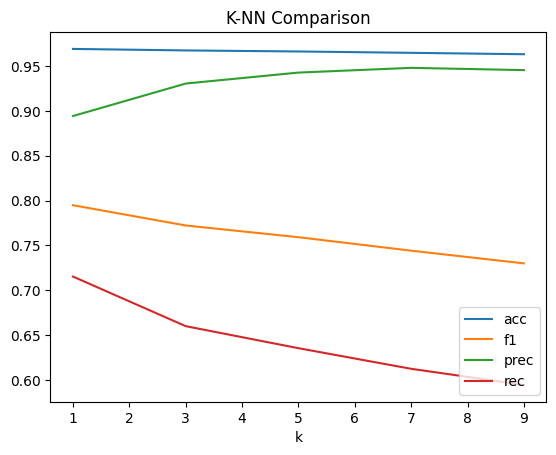

In [5]:
import matplotlib.pyplot as plt

plt.title('K-NN Comparison')
plt.errorbar(ks, accs, label="acc")
plt.errorbar(ks, f1s, label="f1")
plt.errorbar(ks, precs, label="prec")
plt.errorbar(ks, recs, label="rec")
plt.legend(loc ='lower right')
plt.xlabel('k')
plt.show()

Decision Tree

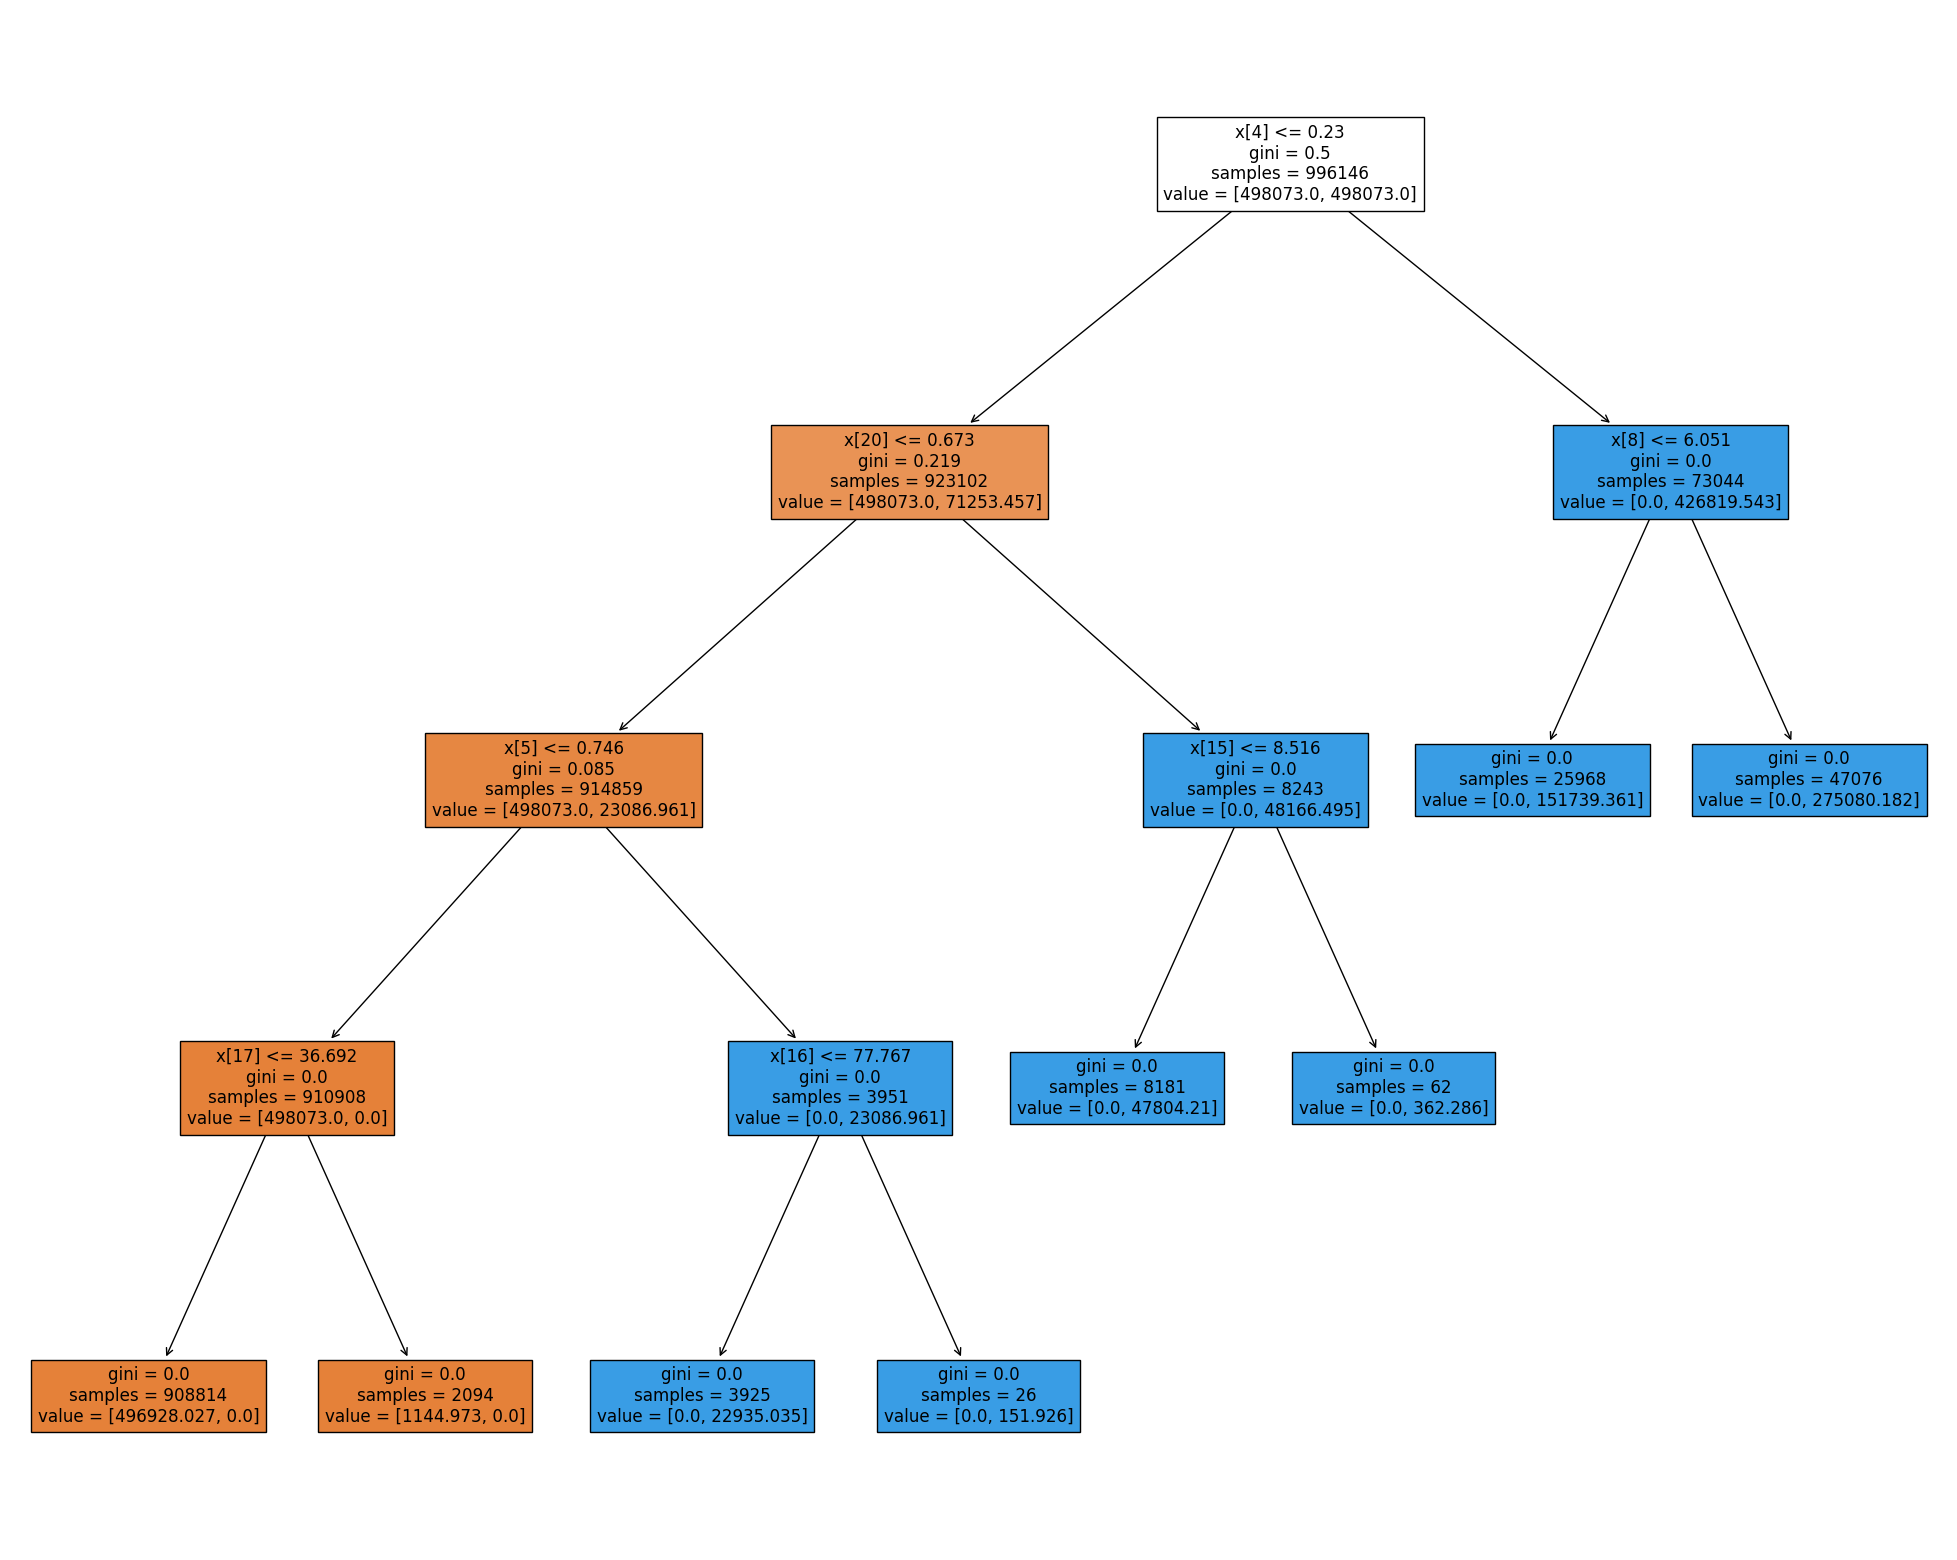

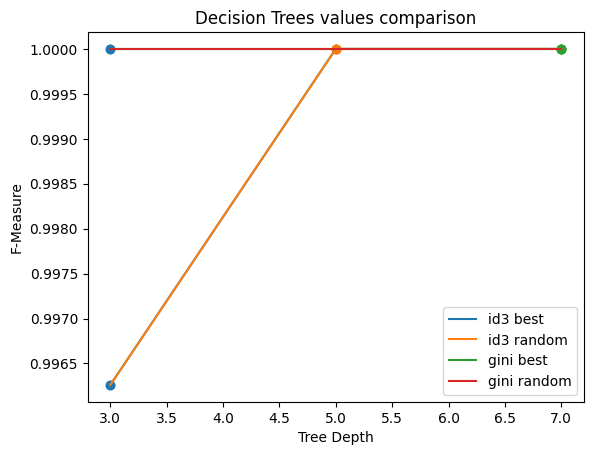

In [34]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

heuristics = ["entropy", "gini"]
splitters = ["best", "random"]
max_depth = [3, 5, 7]
dt_fmeasures = {}
dt_best_result = 0
dt_best = None

for d in max_depth:
    dt_fmeasures[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]:
        # create a Decision Tree classifier instance and compute the prediction
        dt_classifier = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        dt_classifier.fit(train_x, train_y)
        y_pred = dt_classifier.predict(test_x)

        # calculate F-measures and save best model
        acc, f1, prec, rec = get_scores(test_y, y_pred)
        dt_fmeasures[d][i] = acc
        i=i+1

        if f1 > dt_best_result:
            dt_best_result = f1
            dt_best = dt_classifier


